# Finalized Data Preprocessing and Model Creation

In [ ]:
!pip install -r requirements.txt

## Data Preprocessing

In [ ]:
# All the imports that are needed for the models
import keras
import keras_tuner
import sklearn
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from keras.layers import Dense
from keras.models import Sequential
from scikeras.wrappers import KerasRegressor
from keras.optimizers import SGD
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ARDRegression, LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures

In [ ]:
# This is our index of different timezone and major cities within each timezone in the form of a dictionary
cities_by_timezone = {
    'Pacific Time': ['Los Angeles', 'San Francisco Bay Area', 'Seattle', 'Portland', 'San Luis Obispo', 'Sacramento', 'San Diego', 'Santa Barbara', 'Camarillo', 'Fremont', 'Bend', 'Reno', 'Spokane', 'Las Vegas', 'Fresno'],
    'Mountain Time': ['Denver', 'Boulder', 'Salt Lake City', 'Missoula', 'Santa Fe', 'Phoenix', 'Lehi', 'Logan', 'Boise'],
    'Central Time': ['Austin', 'Chicago', 'Minneapolis', 'Milwaukee', 'Nashville', 'Dallas', 'Cincinnati', 'Columbus', 'Indianapolis', 'Nebraska City', 'Kansas City'],
    'Eastern Time': ['New York City', 'Boston', 'Atlanta', 'Ann Arbor', 'Miami', 'Detroit', 'Stamford', 'Washington DC', 'Philadelphia', 'Raleigh', 'Walnut', 'Madison', 'Dover', 'Burlington', 'Wilmington', 'Nashua', 'Baltimore', 'Tampa Bay']
}

def get_timezone(city):
    '''
    Retrieve the timezone associated with a city.

    @type city: string
    @param city: name of city to retrieve timezone for
    @rtype: string, None
    @returns timezone: timezone of a city if in an index; otherwise, None
    '''
    for timezone, cities in cities_by_timezone.items():
        if city in cities:
            return timezone
    return None

[*********************100%***********************]  1 of 1 completed


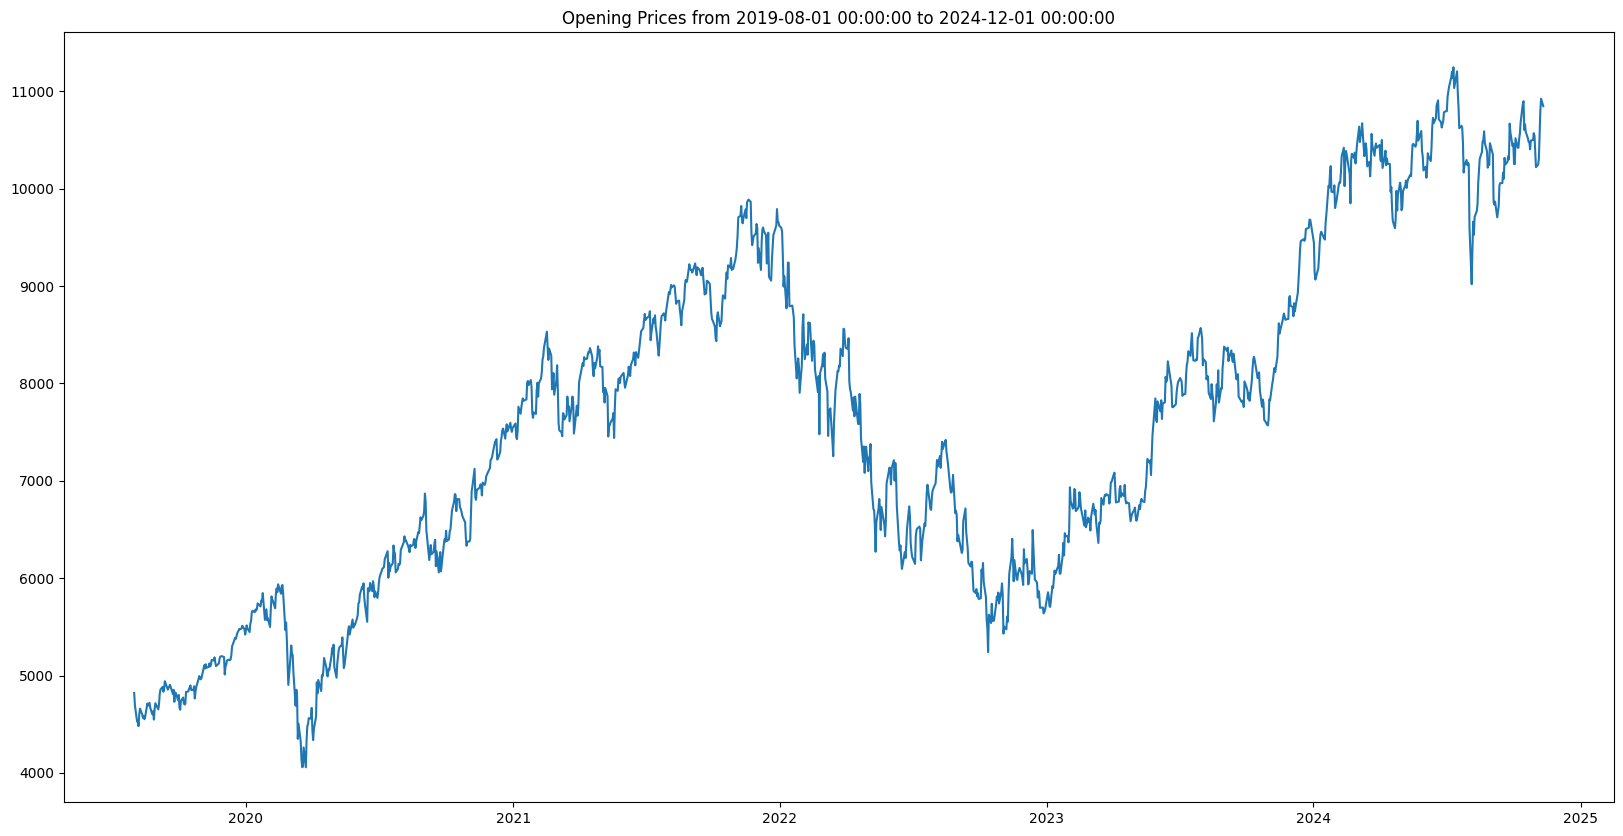

Price                         Adj Close         Close          High  \
Date                                                                  
2019-08-01 00:00:00+00:00   4762.810059   4762.810059   4924.919922   
2019-08-02 00:00:00+00:00   4655.560059   4655.560059   4712.990234   
2019-08-05 00:00:00+00:00   4469.970215   4469.970215   4534.649902   
2019-08-06 00:00:00+00:00   4531.810059   4531.810059   4562.890137   
2019-08-07 00:00:00+00:00   4550.560059   4550.560059   4563.459961   
...                                 ...           ...           ...   
2024-11-05 00:00:00+00:00  10391.540039  10391.540039  10393.200195   
2024-11-06 00:00:00+00:00  10708.440430  10708.440430  10721.009766   
2024-11-07 00:00:00+00:00  10955.730469  10955.730469  10970.269531   
2024-11-08 00:00:00+00:00  10872.200195  10872.200195  10939.969727   
2024-11-11 00:00:00+00:00  10828.709961  10828.709961  10855.679688   

Price                               Low          Open  Volume   price_diff  

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Download NASDAQ 100 data
stock_data = yf.download('^NDXT', start=datetime(2019, 8, 1), end=datetime(2024, 12, 1))
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.get_level_values(0)

def closest_day(row, df):
    target_date = row.name - timedelta(days=90)
    available_dates = df.index
    closest_date = available_dates[available_dates <= target_date].max()
    # if target_date != closest_date:
    #     print(f"target date is: {target_date}")
    #     print(f"closest date: {closest_date}")
    return closest_date

# Calculate 7-day difference in the Open price
stock_data['price_diff'] = stock_data.apply(
    lambda row: row['Open'] - stock_data.loc[closest_day(row, stock_data), 'Open'] if pd.notnull(closest_day(row, stock_data)) else None,
    axis=1
)

stock_data.to_csv('stock_data.csv', index = False, encoding='utf-8')

# Visualize our preliminary stock data of opening prices
plt.figure(figsize = (20,10))
plt.title('Opening Prices from {} to {}'.format(datetime(2019, 8, 1),
                                                datetime(2024, 12, 1)))
plt.plot(stock_data['Open'])
plt.show()

print(stock_data)

In [ ]:
layoff_data = pd.read_csv('tech_layoffs.csv')
print(layoff_data.dtypes)
print(layoff_data.head())

#                                int64
Company                         object
Location_HQ                     object
Region                          object
State                           object
Country                         object
Continent                       object
Laid_Off                       float64
Date_layoffs                    object
Percentage                      object
Company_Size_before_Layoffs     object
Company_Size_after_layoffs      object
Industry                        object
Stage                           object
Money_Raised_in__mil           float64
Year                             int64
latitude                       float64
longitude                      float64
dtype: object
   #        Company    Location_HQ                  Region       State  \
0  1  Tamara Mellon    Los Angeles                     NaN  California   
1  2   HopSkipDrive    Los Angeles                     NaN  California   
2  3    Panda Squad  San Francisco  San Francisco Bay Area  Ca

In [ ]:
import pandas as pd

# Ensure Date_layoffs is in datetime format and remove any timezone information
layoff_data['Date_layoffs'] = pd.to_datetime(layoff_data['Date_layoffs']).dt.tz_localize(None)

# Remove timezone info from stock_data index (if it has timezones)
stock_data.index = stock_data.index.tz_localize(None)

# Function to find the closest available date in stock_data for a given target_date
def find_closest_date(df, target_date):
    available_dates = df.index
    closest_date = available_dates[available_dates <= target_date].max()
    return closest_date

# Function to assign the 90-day price difference (from the stock_data's price_diff column)
def get_stock_delta(layoff_date):
    # Find the closest available date for the layoff date in stock_data
    closest_date = find_closest_date(stock_data, layoff_date)

    # If the closest date is found, return the pre-calculated 'price_diff'
    if pd.notnull(closest_date):
        return stock_data.loc[closest_date, 'price_diff']
    else:
        return None

# Apply the function to assign stock_delta using the pre-calculated 'price_diff' column
layoff_data['stock_delta'] = layoff_data['Date_layoffs'].apply(get_stock_delta)
layoff_data.sort_values(by='Date_layoffs', inplace=True)

# Display the updated DataFrame
layoff_data[['Date_layoffs', 'stock_delta']]


,Date_layoffs,stock_delta
0,2020-03-12,-950.669922
1,2020-03-13,-795.139648
2,2020-03-13,-795.139648
3,2020-03-16,-1064.330078
4,2020-03-16,-1064.330078
...,...,...
1835,2024-06-26,242.679688
1833,2024-06-26,242.679688
1836,2024-06-26,242.679688
1837,2024-06-27,270.879883


In [ ]:
layoff_data['Company'] = layoff_data['Company'].replace({'SaleSan Franciscoorce': 'Salesforce'})

layoff_data['Company_Size_before_Layoffs'] = pd.to_numeric(
    layoff_data['Company_Size_before_Layoffs'].str.replace(',', ''), errors='coerce'
)
layoff_data = layoff_data.sort_index()
layoff_data = layoff_data[(layoff_data['Continent'] == 'North America') &
                          (layoff_data['Country'] == 'USA') &
                          (layoff_data['Company_Size_before_Layoffs'] >= 10)].drop(columns=["Company", "latitude", "longitude", "Continent", "Country", "#"])

# Assign new attribute 'Timezone' based on city
layoff_data['Region'] = layoff_data['Location_HQ'].map(get_timezone)
layoff_data = layoff_data.drop(columns=["Location_HQ", "Company_Size_after_layoffs", "Laid_Off","State"])

#Incorporate stock price
layoff_data = layoff_data.reset_index()


industry_encoder = LabelEncoder()
layoff_data['industry_encoded'] = industry_encoder.fit_transform(layoff_data['Industry'])

time_encoder = LabelEncoder()
layoff_data['Region_encoded'] = time_encoder.fit_transform(layoff_data['Region'])

# Create LabelEncoder instance for stage column
stage_encoder = LabelEncoder()
layoff_data['stage_encoded'] = stage_encoder.fit_transform(layoff_data['Stage'])
layoff_data = layoff_data.drop(columns=["Industry", "Stage","Year","Region"])
layoff_data['Money_Raised_in__mil'] = layoff_data['Money_Raised_in__mil'] * 1000000

#convert date layoffs to unix
layoff_data['Date_layoffs'] = layoff_data['Date_layoffs'].apply(lambda x: int(datetime.timestamp(x)))

# Set our target to be the percentage of a company expected to be laid off at a specific point in time
Y = layoff_data['Percentage'].str.replace(",",".").astype(float)
# Extract and encode our string data such that it makes our data preprocessing more organized
industry = layoff_data['industry_encoded'].values.reshape(-1, 1)
stage = layoff_data['stage_encoded'] .values.reshape(-1, 1)
region = layoff_data['Region_encoded'].values.reshape(-1, 1)

# One-hot encode the string data columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
industry_onehot, stage_onehot, region_onehot = encoder.fit_transform(industry), encoder.fit_transform(stage), encoder.fit_transform(region)

# Drop the original categorical columns from layoff_data
layoff_data = layoff_data.drop(columns=["industry_encoded", "stage_encoded", "Region_encoded", "Percentage"])

display(layoff_data)

print(layoff_data.isnull().sum())


,index,Date_layoffs,Company_Size_before_Layoffs,Money_Raised_in__mil,stock_delta
0,0,1583971200,50.0,90000000.0,-950.669922
1,1,1584057600,80.0,45000000.0,-795.139648
2,3,1584316800,16.0,6000000.0,-1064.330078
3,4,1584316800,591.0,79000000.0,-1064.330078
4,5,1584489600,20.0,4000000.0,-1340.020020
...,...,...,...,...,...
998,1829,1719187200,1000.0,509000000.0,257.769531
999,1830,1719187200,1143.0,100000000.0,257.769531
1000,1836,1719360000,1059.0,574000000.0,242.679688
1001,1837,1719446400,500.0,105000000.0,270.879883


index                           0
Date_layoffs                    0
Company_Size_before_Layoffs     0
Money_Raised_in__mil           39
stock_delta                     0
dtype: int64


In [ ]:
layoff_data["Money_Raised_in__mil"].fillna(layoff_data["Money_Raised_in__mil"].mean(), inplace=True)

<ipython-input-11-c85c003c7c05>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  layoff_data["Money_Raised_in__mil"].fillna(layoff_data["Money_Raised_in__mil"].mean(), inplace=True)


In [ ]:


layoff_data_df = pd.DataFrame(layoff_data)

# Convert one-hot encoded arrays into DataFrames with appropriate column names
industry_onehot_df = pd.DataFrame(industry_onehot, columns=[f'industry_{i}' for i in range(industry_onehot.shape[1])])
stage_onehot_df = pd.DataFrame(stage_onehot, columns=[f'stage_{i}' for i in range(stage_onehot.shape[1])])
region_onehot_df = pd.DataFrame(region_onehot, columns=[f'region_{i}' for i in range(region_onehot.shape[1])])

# Convert Y (Percentage) to a DataFrame
Y_df = pd.DataFrame(Y, columns=["Percentage"])

# Concatenate all data into a single DataFrame
combined_data = pd.concat([layoff_data_df.reset_index(drop=True), industry_onehot_df, stage_onehot_df, region_onehot_df, Y_df], axis=1)

# Save to CSV
combined_data.to_csv("layoff_data_with_onehot.csv", index=False, encoding='utf-8')

print("Data saved to layoff_data_with_onehot.csv")


Data saved to layoff_data_with_onehot.csv


In [ ]:

# Concatenate numerical features and one-hot encoded features, and set it as X
X = np.hstack((layoff_data.values, industry_onehot, stage_onehot, region_onehot))

In [ ]:
# layoff_data.values, industry_onehot, stage_onehot, region_onehot
print("LAYOFF DATA VALS:", str(layoff_data.values[0]))
print("INDUSTRY ONEHOT:", str(industry_onehot[0]))
print("STAGE ONEHOT:", str(stage_onehot[0]))
print("REGION ONEHOT:", str(region_onehot[0]))

print("X:", str(X[0]))

LAYOFF DATA VALS: [ 0.00000000e+00  1.58397120e+09  5.00000000e+01  9.00000000e+07
 -9.50669922e+02]
INDUSTRY ONEHOT: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
STAGE ONEHOT: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
REGION ONEHOT: [0. 0. 1. 0.]
X: [ 0.00000000e+00  1.58397120e+09  5.00000000e+01  9.00000000e+07
 -9.50669922e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [ ]:
# Let's take a look at the shape of our features and our target
X.shape, Y.shape

((1003, 61), (1003,))

In [ ]:
# Assuming X and Y are already sorted by date (chronologically)

# Define the split ratio (e.g., 80% for training, 20% for testing)
train_size = int(0.8 * len(X))  # 80% of the data for training

# Chronologically split the data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# Print the shapes of the resulting sets
print("Training set shapes: X_train =", X_train.shape, ", Y_train =", y_train.shape)
print("Testing set shapes: X_test =", X_test.shape, ", Y_test =", y_test.shape)


Training set shapes: X_train = (802, 61) , Y_train = (802,)
Testing set shapes: X_test = (201, 61) , Y_test = (201,)


In [ ]:
# Finally, let's take a look at our target!
Y

,Percentage
0,40.0
1,10.0
2,100.0
3,22.0
4,20.0
...,...
998,3.0
999,35.0
1000,17.0
1001,4.0


In [ ]:
mse_arr = []
linreg = LinearRegression()

X_train_df, y_train_df = pd.DataFrame(np.array(X_train)), pd.DataFrame(np.array(y_train))

linreg.fit(X_train_df, y_train_df)
yhat_train, yhat_test = linreg.predict(X_train), linreg.predict(X_test)

MSE_train, MSE_test = np.mean((y_train.values - yhat_train)**2), np.mean((y_test.values - yhat_test)**2)
mse_arr.append((MSE_train, MSE_test))
print(f"MSE_train: {MSE_train}\nMSE_test: {MSE_test}")

MSE_train: 464.5621495144079
MSE_test: 651.3433381307756


As we can see, while our Linear Regression model is not awful, it can certainly be a whole lot better. Looking into another form of regression models, Polynomial Regression, we can see how our error change as we add more degrees to our polynomial model

In [ ]:
for k in range(2,4):
    # Create kth degree polynomial
    polyreg = PolynomialFeatures(k)

    # Transform features to fit polynomial model
    train_features = polyreg.fit_transform(X_train_df)
    test_features = polyreg.fit_transform(X_test)

    # Create polynomial regression
    polyreg = LinearRegression()
    polyreg.fit(train_features, y_train_df)

    # Get training and testing predictions
    yhat_train = polyreg.predict(train_features)
    yhat_test = polyreg.predict(test_features)

    # Display training and testing MSEs
    MSE_train = np.mean((y_train.values - yhat_train) ** 2)
    MSE_test = np.mean((y_test.values - yhat_test) ** 2)

    mse_arr.append((MSE_train, MSE_test))
    print(f'Degree: {k}\n    MSE_train: {MSE_train}\n    MSE_test: {MSE_test}')

Degree: 2
    MSE_train: 513.8418175281098
    MSE_test: 2595.4919428224102
Degree: 3
    MSE_train: 489.00602714310776
    MSE_test: 1210.6010928457056


If we graph our data, we can then see how jagged our error measures are for our training and testing data, and how our model may be underfitting due to the difference in complexity between the model and our data.

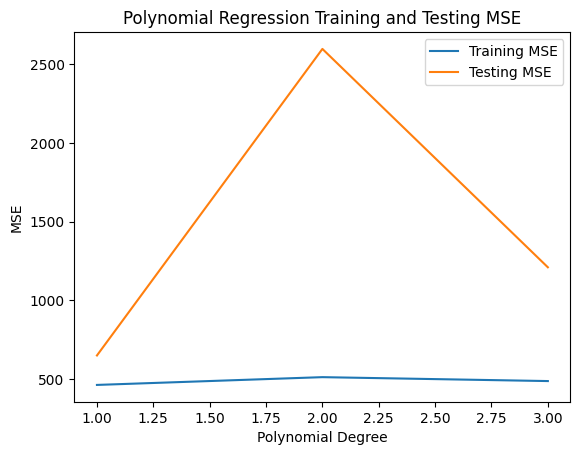

In [ ]:
mse_train = [pair[0] for pair in mse_arr]
mse_test = [pair[1] for pair in mse_arr]

# Plot a graph of the training and testing MSE of the model over time
degrees = range(1, len(mse_arr) + 1)
plt.plot(degrees, mse_train, label='Training MSE')
plt.plot(degrees, mse_test, label='Testing MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Polynomial Regression Training and Testing MSE')
plt.legend()
plt.show()

Finally, we can look at a special regression model called Automatic Relevance Determination Regression. The main premise of this method is that it, similar to Linear Regression, fits a line to the data and determines feature relevance by shrinking irrelevant features.

In [ ]:
ard = ARDRegression().fit(X_train, y_train_df)
yhat_train, yhat_test = ard.predict(X_train), ard.predict(X_test)

MSE_train, MSE_test = np.mean((y_train.values - yhat_train)**2), np.mean((y_test.values - yhat_test)**2)

print(f'Training Mean Squared Error: {MSE_train}\nTesting Mean Squared Error: {MSE_test}')

Training Mean Squared Error: 374.11491016846907
Testing Mean Squared Error: 554.8460415566956


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Model 1: Analysis/Conclusion

From these models, it can be seen that while they are able to fit the data to some degree, they simply do not fit the data well enough to call it a day. Each of these models have their shortcomings when it comes to predicting training or testing data, or even both.

Thus, it would make sense that we would need a model that either illustrates the level of complexity of the model effectively or is specialized in analyzing time series data. For that, we turn to our next two models: a Neural Network and a RandomForestRegressor.

# **LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_lstm_model():
    '''
    Build a more complex LSTM model with stacked LSTM layers, dropout, and additional dense layers for better representation.
    '''
    model = Sequential([
        # First LSTM Layer with 100 units, returns sequences for stacking
        LSTM(100, activation='relu', input_shape=(None, 61), return_sequences=True),
        Dropout(0.3),  # Add dropout to prevent overfitting

        # Second LSTM Layer with 50 units, returns sequences for another layer
        LSTM(50, activation='relu', return_sequences=True),
        Dropout(0.3),

        # Third LSTM Layer with 25 units, doesn't return sequences (last LSTM layer)
        LSTM(25, activation='relu', return_sequences=False),
        Dropout(0.3),

        # First Dense Layer with 50 units
        Dense(50, activation='relu'),
        BatchNormalization(),  # Optional batch normalization for stable training

        # Second Dense Layer with 25 units
        Dense(25, activation='relu'),

        # Output Dense Layer: a single output neuron without any activation (linear)
        Dense(1, activation='linear'),
    ])

    # Compile the model with the Adam optimizer and the learning rate found in the hyperparameter tuning
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mean_squared_error', metrics=['mse'], run_eagerly=True)

    return model

# Example usage: create and compile the LSTM model
lstm_model = build_lstm_model()
lstm_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, None, 100)           │          64,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 50)            │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 50)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 25)                  │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 50)                  │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 105,401 (411.72 KB)

 Trainable params: 105,301 (411.33 KB)

 Non-trainable params: 100 (400.00 B)

In [ ]:
from sklearn.preprocessing import StandardScaler

n = len(X)  # Total number of data points

# Split sizes
train_size = int(0.8 * n)  # 80% for training
val_size = int(0.05 * n)   # 5% for validation
test_size = n - train_size - val_size  # Remaining 15% for testing

# Chronologically splitting the data
X_train, y_train = X[:train_size], Y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], Y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], Y[train_size + val_size:]

# Converting to numpy arrays if needed
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_val_np = scaler.transform(X_val_np)
X_test_np = scaler.transform(X_test_np)

X_train_lstm = np.expand_dims(X_train_np, axis=1)
X_val_lstm = np.expand_dims(X_val_np, axis=1)
X_test_lstm = np.expand_dims(X_test_np, axis=1)

# Check the shape of the data
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_val_lstm shape:", X_val_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)

X_train_lstm shape: (802, 1, 61)
X_val_lstm shape: (50, 1, 61)
X_test_lstm shape: (151, 1, 61)


In [ ]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Build the LSTM model
lstm_model = build_lstm_model()

def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.1
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Train the LSTM model
history = lstm_model.fit(
    X_train_lstm, y_train_np,
    validation_data=(X_val_lstm, y_val_np),
    epochs=30,
    batch_size=16,
    callbacks=[lr_scheduler]
    )

# Evaluate the model on the test set
test_mse = lstm_model.evaluate(X_test_lstm, y_test_np)
print(f"Test MSE: {test_mse}")

# Optionally, make predictions on the test set
y_pred = lstm_model.predict(X_test_lstm)
y_pred_squeezed = np.squeeze(y_pred)
# You can inspect the predictions versus actual values
print("Predictions:", y_pred_squeezed)
print("Actual values:", y_test_np)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - loss: 745.7944 - mse: 745.7944 - val_loss: 330.8677 - val_mse: 330.8677 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - loss: 628.3231 - mse: 628.3231 - val_loss: 342.3730 - val_mse: 342.3730 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - loss: 477.0243 - mse: 477.0243 - val_loss: 313.6943 - val_mse: 313.6943 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 306ms/step - loss: 426.3016 - mse: 426.3016 - val_loss: 253.1551 - val_mse: 253.1551 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - loss: 326.8148 - mse: 326.8148 - 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# Define the bidirectional LSTM model
def build_bidirectional_lstm_model():
    '''
    Build a more complex Bidirectional LSTM model with stacked layers, dropout, and additional dense layers.
    '''
    model = Sequential([
        # First Bidirectional LSTM Layer with 100 units
        Bidirectional(LSTM(1024, activation='relu', return_sequences=True), input_shape=(None, 61)),
        Dropout(0.2),

        # Third Bidirectional LSTM Layer with 25 units
        Bidirectional(LSTM(512, activation='relu', return_sequences=False)),
        Dropout(0.2),

        # First Dense Layer with 50 units
        Dense(256, activation='relu'),
        BatchNormalization(),

        # Second Dense Layer with 25 units
        Dense(128, activation='relu'),
        BatchNormalization(),

        Dense(64, activation='relu'),

        # Output Dense Layer: a single output neuron for regression
        Dense(1, activation='linear'),
    ])

    # Compile the model with the Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mean_absolute_error', metrics=['mae'], run_eagerly=True)

    return model

# Instantiate the bidirectional LSTM model
bidirectional_lstm_model = build_bidirectional_lstm_model()
bidirectional_lstm_model.summary()

# Learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch > 12:
      return lr
    if epoch % 4 == 0 and epoch != 0:
        return lr * 0.1
    return lr

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Train the bidirectional LSTM model
history = bidirectional_lstm_model.fit(
    X_train_lstm, y_train_np,
    validation_data=(X_val_lstm, y_val_np),
    epochs=15,
    batch_size=32,
    callbacks=[lr_scheduler]
)

# Evaluate the model on the test set
test_mse = bidirectional_lstm_model.evaluate(X_test_lstm, y_test_np)
print(f"Test MSE: {test_mse}")

# Make predictions on the test set
y_pred = bidirectional_lstm_model.predict(X_test_lstm)
y_pred_squeezed = np.squeeze(y_pred)

# Display predictions and actual values
print("Predictions:", y_pred_squeezed)
print("Actual values:", y_test_np)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_30 (Bidirectional)     │ (None, None, 2048)          │       8,896,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, None, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_31 (Bidirectional)     │ (None, 1024)                │      10,489,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_154 (Dense)                    │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_155 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_156 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_157 (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,691,521 (75.12 MB)

 Trainable params: 19,690,753 (75.11 MB)

 Non-trainable params: 768 (3.00 KB)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 744ms/step - loss: 19.3513 - mae: 19.3513 - val_loss: 15.7264 - val_mae: 15.7264 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 680ms/step - loss: 12.7673 - mae: 12.7673 - val_loss: 14.1626 - val_mae: 14.1626 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 748ms/step - loss: 10.6578 - mae: 10.6578 - val_loss: 12.7064 - val_mae: 12.7064 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 721ms/step - loss: 9.3418 - mae: 9.3418 - val_loss: 11.6103 - val_mae: 11.6103 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.00010000000474974513.
Epoch 5/15
26

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Example predictions and actual values
predictions = np.array(y_pred_squeezed)
actuals = np.array(y_test_np)
print(len(predictions))
# Calculate absolute differences
differences = np.abs(predictions - actuals)

# Filter out instances where the difference is greater than 10
filtered_indices = differences <= 15
filtered_predictions = predictions[filtered_indices]
filtered_actuals = actuals[filtered_indices]
print(len(filtered_predictions))
# Calculate new metrics on the filtered data
filtered_mse = mean_absolute_error(filtered_actuals, filtered_predictions)

print("Filtered Test MSE:", filtered_mse)

# Optional: Show filtered predictions vs actuals for inspection
print("Filtered Predictions:", filtered_predictions)
print("Filtered Actuals:", filtered_actuals)


151
111
Filtered Test MSE: 4.983391179694785
Filtered Predictions: [13.999018   7.818456   5.909804   9.884777   5.2338333  9.237832
 16.036764   7.3785577  6.0062575  7.7408757  7.091541  13.026573
  7.857703   7.288134   6.152442   6.317916   6.288737   6.1947756
  8.872736  13.655113   6.656348   8.992221   9.328109   6.8664365
  6.8644986  9.204192  11.510823  22.799679  12.920013   7.1512117
 10.753345  10.753443  23.816992   8.433779   7.7748837  9.062793
  6.690485   8.095333   8.571884   8.875746   8.346975   6.434466
 13.391745   8.896269   6.073193   8.968406   9.91153    2.0827973
  7.2082577  5.34417   24.695051   6.525458   6.1602464  7.588098
  5.953923   8.365482   5.6617055  7.3152537  6.1005     6.567996
  7.807774   6.378863   6.7401905 10.486193   6.278523   5.3938937
 13.018482   9.248335   5.8753448  8.761662   5.5202847  6.5529027
  9.094126   7.969195   8.461063  13.812571  19.673103   9.045794
  9.691313   7.903279   6.386264  15.493494   9.633976   8.859931
  7